# Working with the Multi-bjective Knapsack Problem
MetaJul includes a implementation of the multi-objective 0-1 knapsack problem (MOKP) allowing multiple objectives (profits) and multiple constraints. As the profits are objectives to maximize, their values are multiplied by -1 as MetaJul assumes minimization by default.

In [3]:
using MetaJul

Precompiling MetaJul
  ✓ MetaJul
  1 dependency successfully precompiled in 3 seconds. 208 already precompiled.


## Defining a single objective MOKP

In [4]:
profits = [10 5 15 7;]
weights = [2 3 5 7 ;]
capacities = [12]

singleObjectiveKnapsack = multiObjectiveKnapsack(profits, weights, capacities)

BinaryProblem(4, Function[MetaJul.var"#241#243"{Matrix{Int64}, Int64, Int64}([10 5 15 7], 4, 1)], Function[MetaJul.var"#242#244"{Matrix{Int64}, Vector{Int64}, Int64, Int64}([2 3 5 7], [12], 4, 1)], "MultiObjectiveKnapsack")

In [5]:
println("Number of variables  : ", numberOfVariables(singleObjectiveKnapsack))
println("Number of objectives : ", numberOfObjectives(singleObjectiveKnapsack))
println("NUmber of constraints: ", numberOfConstraints(singleObjectiveKnapsack))

Number of variables  : 4
Number of objectives : 1
NUmber of constraints: 1


In [6]:
# Creating and evaluating a feasible solution
solution = createSolution(singleObjectiveKnapsack)
solution.variables = initBitVector("1010")

evaluate(solution, singleObjectiveKnapsack)

println("Solution objectives: ", -1 * solution.objectives)
println("Feasibility check  : ", isFeasible(solution));

Solution objectives: [25]
Feasibility check  : true


## Defining a bi-objective MOKP with three constraints

In [7]:
profits = [10 5 15 7 ; 2 6 3 4]
weights = [2 3 5 7 ; 1 5 6 3 ; 3 1 2 4]
capacities = [12, 9, 5]

biObjectiveKnapsack = multiObjectiveKnapsack(profits, weights, capacities);

In [8]:
println("Number of variables  : ", numberOfVariables(biObjectiveKnapsack))
println("Number of objectives : ", numberOfObjectives(biObjectiveKnapsack))
println("NUmber of constraints: ", numberOfConstraints(biObjectiveKnapsack))

Number of variables  : 4
Number of objectives : 2
NUmber of constraints: 3


In [9]:
# Creating and evaluating a feasible solution
solution = createSolution(biObjectiveKnapsack)
solution.variables = initBitVector("1010")

evaluate(solution, biObjectiveKnapsack)

println("Solution objectives: ", -1 * solution.objectives)
println("Feasibility check  : ", isFeasible(solution));

Solution objectives: [25, 5]
Feasibility check  : true


In [10]:
# Creating and evaluating a solution violating two constraints
solution = createSolution(biObjectiveKnapsack)
solution.variables = initBitVector("1110")

evaluate(solution, biObjectiveKnapsack)

println("Solution objectives: ", -1 * solution.objectives)
println("Feasibility check  : ", isFeasible(solution))
println("Number of violated constraints: ", numberOfViolatedConstraints(solution))
println("Overall constraint violation degree: ", overallConstraintViolationDegree(solution))

Solution objectives: [30, 11]
Feasibility check  : false
Number of violated constraints: 2
Overall constraint violation degree: -4


In [11]:
# Creating and evaluating a solution violating three constraints
solution = createSolution(biObjectiveKnapsack)
solution.variables = initBitVector("1111")

evaluate(solution, biObjectiveKnapsack)

println("Solution objectives: ", -1 * solution.objectives)
println("Feasibility check  : ", isFeasible(solution))
println("Number of violated constraints: ", numberOfViolatedConstraints(solution))
println("Overall constraint violation degree: ", overallConstraintViolationDegree(solution))

Solution objectives: [37, 15]
Feasibility check  : false
Number of violated constraints: 3
Overall constraint violation degree: -16


## Solving a MOKP with NSGA-II

In [12]:
# Creating a randomly initialized bi-objective instance

using Random
Random.seed!(42)

rows, cols = 2, 100

profits = rand(5:20, rows, cols)
weights = rand(1:20, 1, cols)
capacities = [150; ]

biObjectiveKnapsack = multiObjectiveKnapsack(profits, weights, capacities);

In [13]:
println("Number of variables  : ", numberOfVariables(biObjectiveKnapsack))
println("Number of objectives : ", numberOfObjectives(biObjectiveKnapsack))
println("NUmber of constraints: ", numberOfConstraints(biObjectiveKnapsack))

Number of variables  : 100
Number of objectives : 2
NUmber of constraints: 1


In [14]:
# Configuring NSGA-II

solver::NSGAII = NSGAII(
        biObjectiveKnapsack, 
        populationSize = 100, 
        termination = TerminationByEvaluations(50000),
        mutation = BitFlipMutation(probability = 1.0 / biObjectiveKnapsack.numberOfBits),
        crossover = SinglePointCrossover(probability = 1.0)
        )

solver.dominanceComparator = ConstraintsAndDominanceComparator();

In [15]:
optimize!(solver) ;

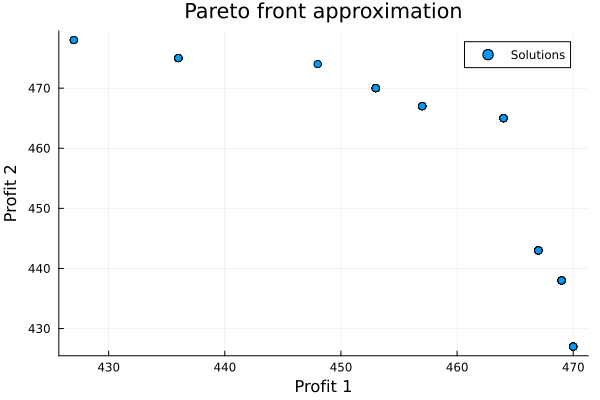

In [16]:
# Plot the obtained solutions

x = [-1 * solution.objectives[1] for solution in foundSolutions(solver)];
y = [-1 * solution.objectives[2] for solution in foundSolutions(solver)];
 
using Plots
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("Profit 1")
ylabel!("Profit 2")

In [57]:
# Checking that solutions are feasible
solutionsAreFeasible = all(solution -> isFeasible(solution), foundSolutions(solver))

true